In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tempfile
from Data_Processing import load_data, one_hot_encode
%matplotlib inline
plt.style.use('ggplot')

/home/tiger/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos] # if x.device_type == 'GPU']

print(get_available_gpus())

['/device:CPU:0', '/device:GPU:0']


In [3]:
parent_dir = "./UrbanSound8K/audio/"
file_title = "delta"
train_folds = np.array(range(1,9)) #first 8 folds as training set
dev_folds = np.array([9]) #9th fold as dev set
test_folds = np.array([10]) #10th fold as test set

In [4]:
train_pd, dev_pd, test_pd = load_data(parent_dir, file_title, train_folds, dev_folds, test_folds)

done!


In [5]:
print(train_pd.shape)
print(dev_pd.shape)
print(test_pd.shape)
train_pd.head()

(44074, 1643)
(5149, 1643)
(5248, 1643)


,0,1,2,3,4,5,6,7,8,9,...,1633,1634,1635,1636,1637,1638,1639,label,labels_name,file_name
0,-36.037760,-2.392662,-41.881958,-2.638279,-45.590943,-2.865359,-51.973699,-2.774081,-53.738091,-2.622057,...,8.881784e-16,-59.990892,8.881784e-16,-59.990892,8.881784e-16,-59.990892,8.881784e-16,3,dog_bark,101415-3-0-2.wav
1,-26.529043,-0.858474,-34.891898,-0.885828,-26.180946,-0.776784,-35.924429,-1.041078,-30.442950,-1.223562,...,-1.604131e-01,-52.324747,-1.332268e-15,-52.324747,-1.332268e-15,-52.324747,-1.332268e-15,3,dog_bark,101415-3-0-2.wav
2,-31.785712,-2.722036,-41.360488,-2.781311,-47.712957,-2.418076,-48.900445,-2.290517,-49.422880,-1.820642,...,-1.332268e-15,-52.324747,-1.332268e-15,-52.324747,-1.332268e-15,-52.324747,-1.332268e-15,3,dog_bark,101415-3-0-2.wav
3,-32.721241,0.064818,-34.766695,-0.177125,-27.381779,-1.121687,-32.609742,-1.627513,-33.990963,-2.146081,...,2.173804e-01,-58.721579,4.681865e-01,-58.297458,5.614477e-01,-56.783714,5.316547e-01,3,dog_bark,101415-3-0-2.wav
4,-31.090242,-2.652109,-40.461241,-3.111727,-48.808788,-3.199862,-46.231048,-2.936431,-48.314255,-2.310369,...,-7.650794e-01,-40.876589,-7.349432e-01,-42.187831,-8.415271e-01,-44.714906,-1.174488e+00,3,dog_bark,101415-3-0-2.wav


In [6]:

train_x, train_y = train_pd.iloc[:, 0:1640].values, train_pd.iloc[:, 1640].values
dev_x, dev_y = dev_pd.iloc[:, 0:1640].values, dev_pd.iloc[:, 1640].values
test_x, test_y = test_pd.iloc[:, 0:1640].values, test_pd.iloc[:, 1640].values

#use part of the training sets to save training time, use the full datasets when have enough computing power
train_x, train_y = train_x[0:12800, :], train_y[0:12800]


In [7]:



def weight_variable(shape, name):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name = name)


def bias_variable(shape, name):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)


In [8]:
training_iters = 20000
lr = 2e-3
batch_size = 256
hidden_dense = 1000

# Build the CNN structure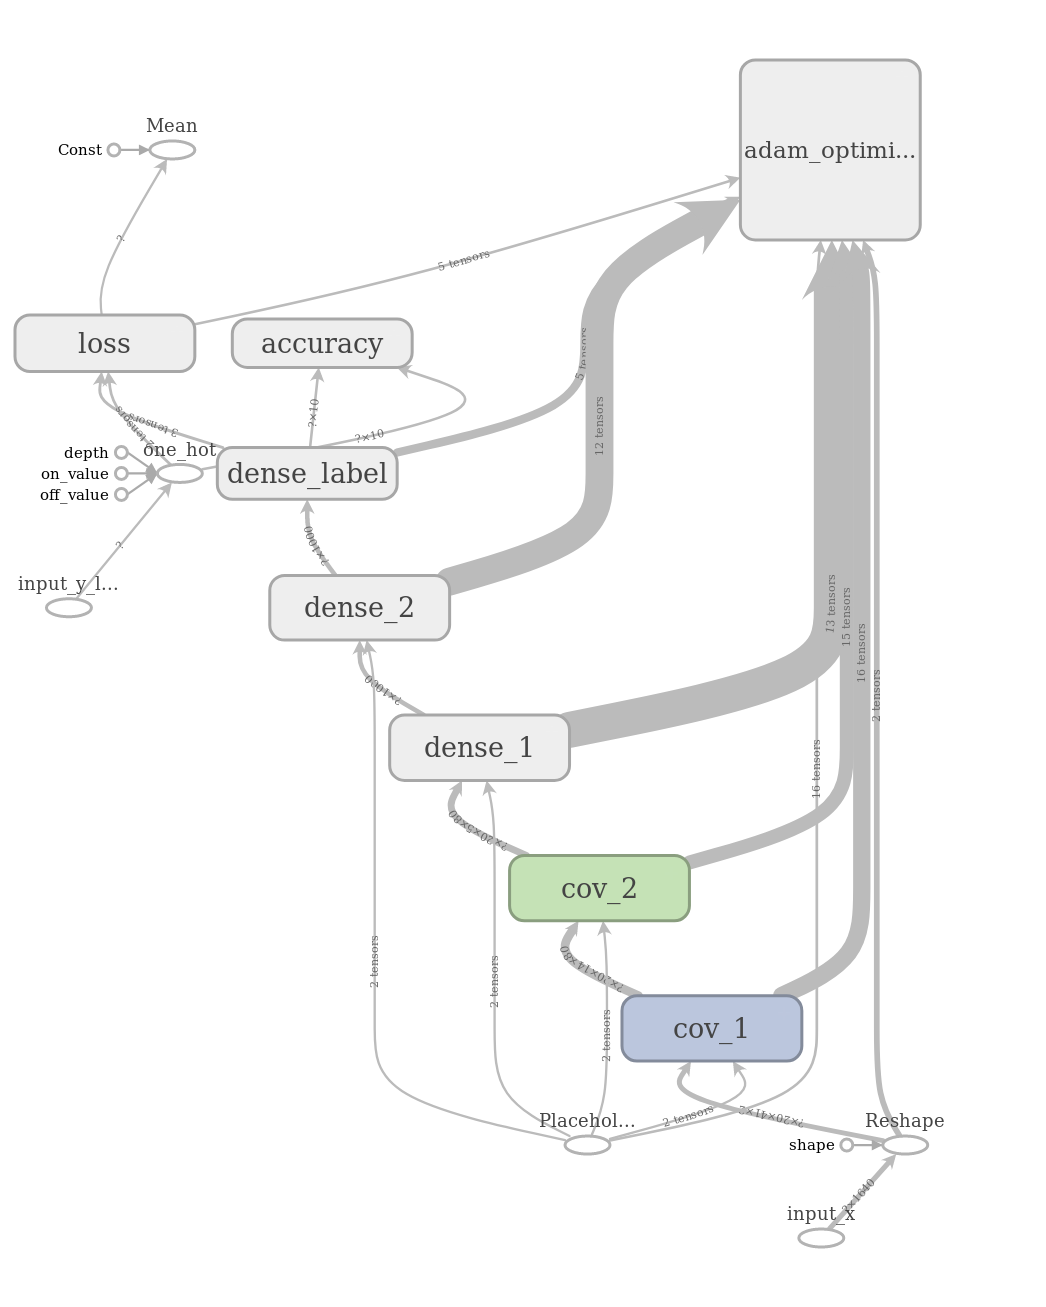

In [9]:
def urban_cnn(x): #, is_training = True) #, sess):
    
    x_cnn = tf.reshape(x, [-1, 20, 41, 2])
    keep_prob = tf.placeholder(tf.float32)
    """
    The first convolutional ReLU layer consisted of 80 filters
    of rectangular shape (17×6 size, 1×1 stride) allowing
    for slight frequency invariance. Max-pooling was applied
    with a pool shape of 1×3 and stride of 1×3.
    """
    with tf.variable_scope("cov_1", reuse=tf.AUTO_REUSE) as scope:
  
        W_conv1 = weight_variable([17, 6, 2, 80], name = "W_Conv1")
        #scope.reuse_variables() 
        b_conv1 = bias_variable([80], name = "W_CB1")

        wc1_regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

        wc1_weights = tf.get_variable(
            name="W_Conv1",
            shape = [17, 6, 2, 80],
            regularizer=wc1_regularizer
        )
        #shape [-1, 20,41,80]
        h_conv1 = tf.nn.relu(tf.nn.conv2d(x_cnn, wc1_weights, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
        
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding = "SAME") 
        #endup shape [-1, 20, 14, 80]
  
        h_conv1_drop = tf.nn.dropout(h_pool1, keep_prob= keep_prob) 

    """
    A second convolutional ReLU layer consisted of 80 filters
    (1×3 size, 1×1 stride) with max-pooling (1×3 pool size,
    1×3 pool stride)
    """
    with tf.variable_scope("cov_2", reuse=tf.AUTO_REUSE) as scope_2:
        W_conv2 = weight_variable([1, 3, 80, 80], name = "W_Conv2")
        #scope_2.reuse_variables()         
        b_conv2 = bias_variable([80], name = "W_CB2")

        
        wc2_regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

        wc2_weights = tf.get_variable(
            name="W_Conv2",
            shape = [1, 3, 80, 80],
            regularizer= wc2_regularizer
        )
        #shape [-1, 20, 14, 80]
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1_drop, wc2_weights, strides = [1, 1, 1, 1], padding="SAME") + b_conv2)
        #endup shape [-1, 20, 5, 80]
        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding = "SAME") 
        h_conv2_drop = tf.nn.dropout(h_pool2, keep_prob= keep_prob) 

    """
    Further processing was applied through two fully connected hidden layers of 
    1000 ReLUs each and a softmax output layer.
    """ 
    
    with tf.variable_scope("dense_1", reuse=tf.AUTO_REUSE) as scope:
         
        W_fc1 = weight_variable([20 * 5 * 80, hidden_dense], name = "W_fc1")
        #scope.reuse_variables()
        b_fc1 = bias_variable([hidden_dense], name = "B_fc1")
        
        
        wfc1_regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

        wfc1_weights = tf.get_variable(
            name="W_fc1",
            shape = [20 * 5 * 80, hidden_dense], 
            regularizer=wfc1_regularizer
        )
        
        h_conv2_drop_flat = tf.reshape(h_conv2_drop, [-1, 20*5*80])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv2_drop_flat, wfc1_weights) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob = keep_prob)
    
    with tf.variable_scope("dense_2", reuse=tf.AUTO_REUSE) as scope:
    
        W_fc2= weight_variable([hidden_dense, hidden_dense], name = "W_fc2")
        b_fc2 = bias_variable([hidden_dense], name = "B_fc2")
        #scope.reuse_variables() 
        wfc2_regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

        wfc2_weights = tf.get_variable(
            name="W_fc2",
            shape = [hidden_dense, hidden_dense],
            regularizer=wfc2_regularizer
        )

        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, wfc2_weights) + b_fc2)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob = keep_prob)
    
    with tf.variable_scope("dense_label", reuse=tf.AUTO_REUSE) as scope:
        W_fc3 = weight_variable([hidden_dense, 10], name = "W_fc3")
        b_fc3 = bias_variable([10], name = "B_fc3")

        y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
    
    return y_conv, keep_prob



# Training session

In [10]:
def testing(session, correct_num, test_x, test_y):
    l_range = test_x.shape[0] // batch_size if test_x.shape[0] % batch_size else test_x.shape[0] // batch_size + 1
    
    correct = 0
    
    for i in range(l_range):
        offset = (i * batch_size) 
        
        test_bx = test_x[offset: (offset + batch_size), :]
        test_by = test_y[offset: (offset + batch_size)]
        
        correct += session.run(correct_num, feed_dict = {x : test_bx, y_label : test_by, keep_prob: 1})
        
    return float(correct)/test_x.shape[0]

In [11]:
x = tf.placeholder(tf.float32, [None, 20 * 41 * 2], name = "input_x")

# Define loss and optimizer
y_label = tf.placeholder(tf.int32, [None], name = "input_y_label")
y_ = tf.one_hot(indices=tf.cast(y_label, tf.int32), depth=10)

# Build the graph for the deep net
y_conv, keep_prob = urban_cnn(x)

with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
    cross_entropy_sum = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                        logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy_sum)

with tf.variable_scope('adam_optimizer', reuse=tf.AUTO_REUSE):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

with tf.variable_scope('accuracy', reuse=tf.AUTO_REUSE):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    correct_num = tf.reduce_sum(correct_prediction)
    batch_accuracy = tf.reduce_mean(correct_prediction)

graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for itr in range(training_iters):    
        offset = (itr * batch_size) % (train_x.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :]
        batch_y = train_y[offset:(offset + batch_size)]
        
        _, loss = sess.run([train_step, cross_entropy], feed_dict={x: batch_x, y_label: batch_y, keep_prob: 0.5})
        
        if((itr+1)%300 ==0):
            train_accuracy = batch_accuracy.eval(feed_dict={
                x: batch_x, y_label: batch_y, keep_prob: 1.0})
            print("Iter " + str(itr) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss))
            print('step %d, training batch accuracy %g' % (itr, train_accuracy))
        if((itr+1)%1000==0):
            test_accuracy = testing(sess, correct_num, test_x, test_y)
            print("Iter " + str(itr) + ", Test Accuracy= " + \
                  "{:.5f}".format(test_accuracy))


Saving graph to: /tmp/tmpo7fv0zik
Iter 299, Minibatch Loss= 2.072187
step 299, training batch accuracy 0
Iter 599, Minibatch Loss= 2.107592
step 599, training batch accuracy 0.433594
Iter 899, Minibatch Loss= 2.608537
step 899, training batch accuracy 0
Iter 999, Test Accuracy= 0.18197
Iter 1199, Minibatch Loss= 2.175366
step 1199, training batch accuracy 0.15625
Iter 1499, Minibatch Loss= 2.068566
step 1499, training batch accuracy 0.21875
Iter 1799, Minibatch Loss= 1.394876
step 1799, training batch accuracy 0.988281
Iter 1999, Test Accuracy= 0.26543
Iter 2099, Minibatch Loss= 2.000344
step 2099, training batch accuracy 0.53125
Iter 2399, Minibatch Loss= 1.695270
step 2399, training batch accuracy 0.488281
Iter 2699, Minibatch Loss= 1.322472
step 2699, training batch accuracy 0.714844
Iter 2999, Minibatch Loss= 1.009573
step 2999, training batch accuracy 0.964844
Iter 2999, Test Accuracy= 0.38681
Iter 3299, Minibatch Loss= 1.257212
step 3299, training batch accuracy 0.675781
Iter 359

In [ ]:
sess.close()